Functional CNN for RetinaMnist

# Importing Libraries

In [1]:
!pip install medmnist

     |████████████████████████████████| 87 kB 3.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=3e32eb9eb29f722f7065a157d0f45c72879fa1cb99a4d621eb8eb8d40b7fbf13
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1
from tensorflow.image import adjust_brightness
from tensorflow.keras import layers, models
from sklearn import metrics
from keras.layers.merge import concatenate
from matplotlib import pyplot as plt
from skimage.transform import rotate
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.callbacks import ModelCheckpoint, Callback , EarlyStopping
from medmnist import RetinaMNIST
from keras.preprocessing.image import img_to_array

from sklearn.metrics import roc_auc_score
import cv2
import keras.backend as K

# Loading Dataset


## Method 1 - Using wget

In [3]:
!wget -O RetinaData.npz https://zenodo.org/record/4269852/files/retinamnist.npz?download=1

--2022-05-19 01:49:08--  https://zenodo.org/record/4269852/files/retinamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3291041 (3.1M) [application/octet-stream]
Saving to: ‘RetinaData.npz’

RetinaData.npz      100%[===================>]   3.14M  3.78MB/s    in 0.8s    

2022-05-19 01:49:11 (3.78 MB/s) - ‘RetinaData.npz’ saved [3291041/3291041]



In [4]:
data = np.load('RetinaData.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [5]:
X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

## Method 2 - Importing RetinaMNIST from MedMNIST


In [6]:
data_new_train = RetinaMNIST(split='train',download=True)
data_new_val = RetinaMNIST(split='val',download=True)
data_new_test = RetinaMNIST(split='test',download=True)

  0%|          | 0/3291041 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


In [7]:
dataset_train = []
label_train = []
for i in data_new_train:
  dataset_train.append((img_to_array(i[0])))
  label_train.append(i[1])

In [8]:
dataset_val = []
label_val = []
for i in data_new_val:
  dataset_val.append((img_to_array(i[0])))
  label_val.append(i[1])

In [9]:
dataset_test = []
label_test = []
for i in data_new_test:
  dataset_test.append((img_to_array(i[0])))
  label_test.append(i[1])

In [10]:
train_X = np.array(dataset_train)
train_y = np.array(label_train)
val_X = np.array(dataset_val)
val_y = np.array(label_val)
test_X = np.array(dataset_test)
test_y = np.array(label_test)

## comparing datasets downloaded from different methods

In [11]:
print((train_X == X_train).all())
print((train_y == y_train).all())
print((val_X == X_val).all())
print((val_y == y_val).all())
print((test_X == X_test).all())
print((test_y == y_test).all())

True
True
True
True
True
True


## verifying the dataset

In [12]:
print(np.isnan(train_X).sum())
print(np.isnan(train_y).sum())
print(np.isnan(val_X).sum())
print(np.isnan(val_y).sum())
print(np.isnan(test_X).sum())
print(np.isnan(test_y).sum())

0
0
0
0
0
0


In [13]:
print(f'Train Set:      X:%s Y:%s' %(train_X.shape, train_y.shape))
print(f'Validation Set: X:%s  Y:%s' %(val_X.shape, val_y.shape))
print(f'Test Set :      X:%s  Y:%s' %(test_X.shape, test_y.shape))

Train Set:      X:(1080, 28, 28, 3) Y:(1080, 1)
Validation Set: X:(120, 28, 28, 3)  Y:(120, 1)
Test Set :      X:(400, 28, 28, 3)  Y:(400, 1)


# Visualizing the Dataset

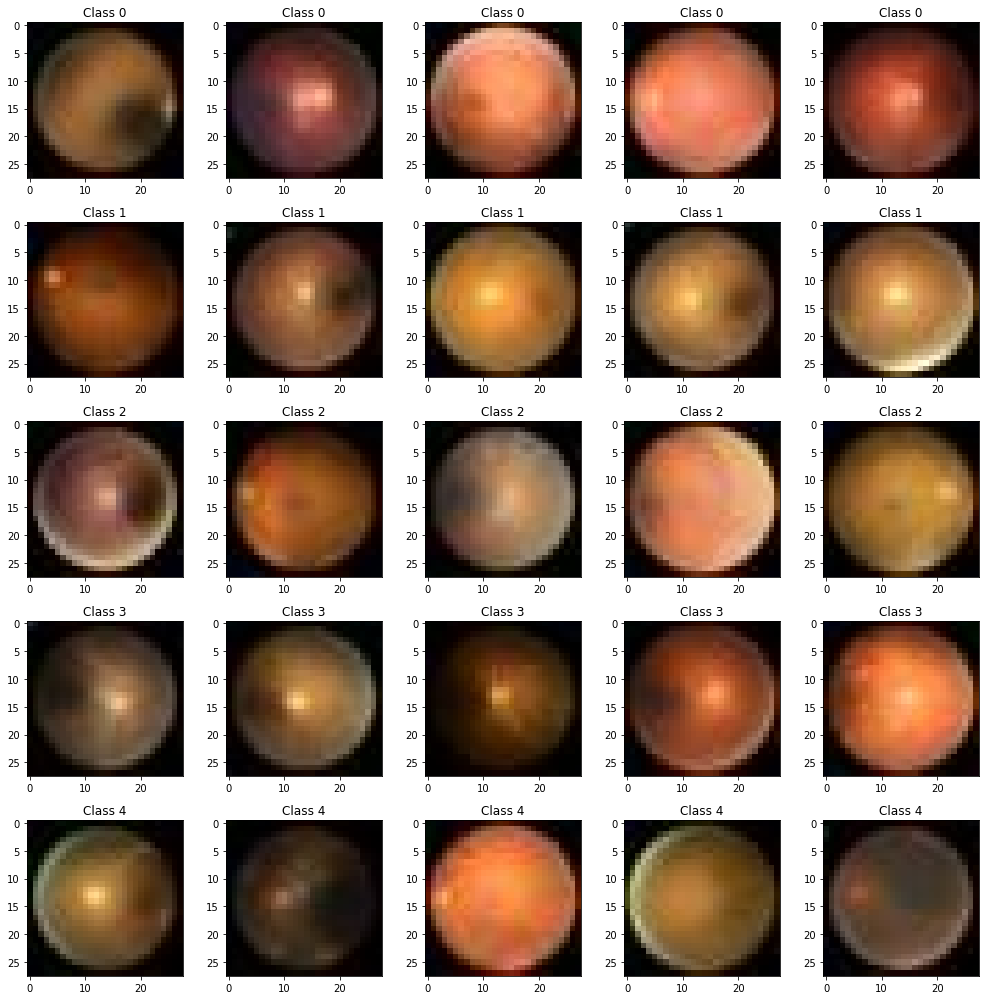

In [14]:
no_classes = len(np.unique(y_train))
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
for c in range(no_classes):
    indexes = np.where(y_train == c)[0][:no_classes]
    class_images = [X_train[i] for i in indexes]
    for i in range(no_classes):
        t = f'Class {c}'
        axes[c, i].set_title(t)
        axes[c, i].imshow(class_images[i])
plt.tight_layout()

# Data Pre-Processing

## Checking for different samples available for each label

In [15]:
def get_classes_dist(y):
    count = [0 for i in range(5)]
    for i in y:
      count[i] += 1
    return count

In [16]:
print(f"Train      => {get_classes_dist(train_y.reshape(-1,))}")
print(f"Validation => {get_classes_dist(val_y.reshape(-1,))}")
print(f"Test       => {get_classes_dist(test_y.reshape(-1,))}")

Train      => [486, 128, 206, 194, 66]
Validation => [54, 12, 28, 20, 6]
Test       => [174, 46, 92, 68, 20]


## Data Augmentation for all the classes execpt 'Class 0'

In [17]:
train_X_temp = train_X
train_y_temp = train_y
X_augmented = train_X_temp
y_augmented = train_y_temp.reshape(-1,)

In [18]:
for i in range(train_X_temp.shape[0]):
    y = train_y_temp.reshape(-1,)[i]
    if y == 0:
        continue
    elif y == 1:
        X_augmented = np.append(X_augmented, [ adjust_brightness(train_X_temp[i], delta=0.2), adjust_brightness(train_X_temp[i], delta=-0.2), adjust_brightness(train_X_temp[i], delta=0.3)], axis=0)
        y_augmented = np.append(y_augmented, [y, y, y], axis=0)
    elif y == 2:
        X_augmented = np.append(X_augmented, [adjust_brightness(train_X_temp[i], delta=0.3)], axis=0)
        y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 3:
         X_augmented = np.append(X_augmented, [adjust_brightness(train_X_temp[i], delta=0.3)], axis=0)
         y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 4:
        X_augmented = np.append(X_augmented, [adjust_brightness(train_X_temp[i], delta=0.1), adjust_brightness(train_X_temp[1], delta=-0.2)], axis=0)
        X_augmented = np.append(X_augmented, [adjust_brightness(train_X_temp[i], delta=0.3), adjust_brightness(train_X_temp[1], delta=-0.1)], axis=0)
        X_augmented = np.append(X_augmented, [adjust_brightness(train_X_temp[i], delta=0.2), adjust_brightness(train_X_temp[1], delta=0.5)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y,y], axis=0)

In [19]:
print(f"Shape of dataset after augmentation => {X_augmented.shape}")
print(f"Different Labels => {get_classes_dist(y_augmented.reshape(-1,))}")

Shape of dataset after augmentation => (2260, 28, 28, 3)
Different Labels => [486, 512, 412, 388, 462]


## Normalization

In [20]:
feature_train = train_X/255
feature_test = test_X/255
feature_val = val_X/255
feature_aug = X_augmented/255

## One Hot Encoding

In [21]:
target_train = tf.keras.utils.to_categorical(train_y)
target_val = tf.keras.utils.to_categorical(val_y)
target_test = tf.keras.utils.to_categorical(test_y)
target_aug = tf.keras.utils.to_categorical(y_augmented)

# Defining custom Evaluation Metrics, Optimizers, EarlyStopping

In [22]:
## Refrence - https://neptune.ai/blog/keras-metrics

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
opt_r = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
opt_a = tf.keras.optimizers.Adamax(learning_rate = 0.0001)
opt_s = tf.keras.optimizers.SGD(learning_rate = 0.005)

In [24]:
callbacks = [EarlyStopping ( monitor = "val_loss", patience= 5)]

In [25]:
width, height, channels = 28,28,3
if K.image_data_format() == 'channels_first':
    input_shape = (channels, width, height)
else:
    input_shape = (width, width, channels)

# Functional CNN (Model 2)

In [26]:
img_inputs = keras.Input(shape=input_shape)

conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same')(img_inputs)
conv_2 = keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same')(conv_1)
maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(maxpool_1)
maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_3)
flat1 = keras.layers.Flatten()(maxpool_2)
conv_4 = keras.layers.Conv2D(128, (3, 3), activation='relu')(maxpool_1)
maxpool_3 = keras.layers.MaxPooling2D((2, 2))(conv_4)
conv_5 = keras.layers.Conv2D(256, (3, 3), activation='relu')(maxpool_3)
maxpool_4 = keras.layers.MaxPooling2D((2, 2))(conv_5)
flat2 = keras.layers.Flatten()(maxpool_4)
merge = concatenate([flat1, flat2])
hidden1 = keras.layers.Dense(500, 'relu')(merge)
hidden2 = keras.layers.Dense(250, 'relu')(hidden1)
dropout = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(100, 'relu')(dropout)
hidden4 = keras.layers.Dense(50, 'relu')(hidden3)
output = keras.layers.Dense(5, 'softmax')(hidden4)

network_functional = keras.Model(inputs=img_inputs, outputs=output)

In [27]:
network_functional.compile(
              optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=['accuracy',Recall(), Precision(), AUC()])

In [28]:
history_functional =  network_functional.fit(
            feature_train, target_train, 
            epochs=60, 
            batch_size=16, 
            validation_data=(feature_val, target_val),
            callbacks = callbacks)

Epoch 1/60
68/68 [==============================] - 15s 20ms/step - loss: 1.4019 - accuracy: 0.4500 - recall: 0.1972 - precision: 0.6961 - auc: 0.7159 - val_loss: 1.3219 - val_accuracy: 0.4500 - val_recall: 0.2333 - val_precision: 0.8485 - val_auc: 0.7772
Epoch 2/60
68/68 [==============================] - 1s 8ms/step - loss: 1.3115 - accuracy: 0.4491 - recall: 0.2657 - precision: 0.7653 - auc: 0.7647 - val_loss: 1.2021 - val_accuracy: 0.4333 - val_recall: 0.3000 - val_precision: 0.9730 - val_auc: 0.8012
Epoch 3/60
68/68 [==============================] - 1s 8ms/step - loss: 1.2228 - accuracy: 0.4991 - recall: 0.3157 - precision: 0.8042 - auc: 0.7904 - val_loss: 1.1307 - val_accuracy: 0.4917 - val_recall: 0.3000 - val_precision: 1.0000 - val_auc: 0.8250
Epoch 4/60
68/68 [==============================] - 1s 8ms/step - loss: 1.1925 - accuracy: 0.4917 - recall: 0.3213 - precision: 0.8321 - auc: 0.8004 - val_loss: 1.0985 - val_accuracy: 0.5083 - val_recall: 0.3000 - val_precision: 0.9474 

In [29]:
training_loss = history_functional.history["loss"]
test_loss = history_functional.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

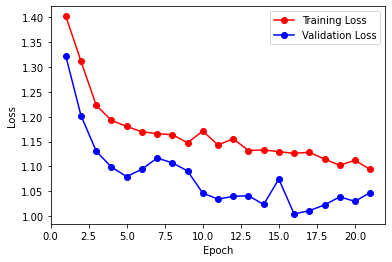

In [30]:
# visualise loss history
plt.plot(epoch_count, training_loss, "r-o")
plt.plot(epoch_count, test_loss, "b-o")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

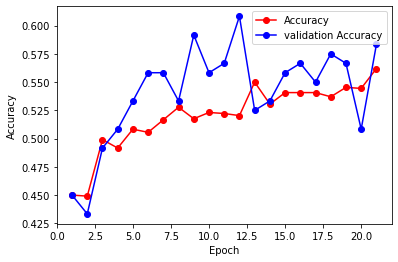

In [31]:
training_accuracy= history_functional.history["accuracy"]
testing_accuracy= history_functional.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r-o")
plt.plot(epoch_count, testing_accuracy, "b-o")
plt.legend(["Accuracy", "validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

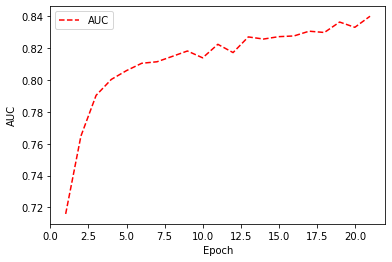

In [33]:
plt.plot(epoch_count, history_functional.history["auc"], "r--")
plt.legend(["AUC"])
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

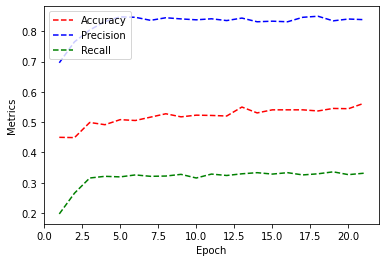

In [35]:
training_accuracy= history_functional.history["accuracy"]
training_precision= history_functional.history["precision"]
training_recall= history_functional.history["recall"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, training_precision, "b--")
plt.plot(epoch_count, training_recall, "g--")
plt.legend(["Accuracy", "Precision","Recall"])
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.show()

In [36]:
score_seq  = network_functional.evaluate(feature_test, target_test,verbose = 0)
print(f"Test Accuracy : {np.round(score_seq[1],2)}")
print(f"Test Recall : {np.round(score_seq[2],2)}")
print(f"Test Precision : {np.round(score_seq[3],2)}")
print(f"Test AUC : {np.round(score_seq[4],2)}")

Test Accuracy : 0.56
Test Recall : 0.31
Test Precision : 0.83
Test AUC : 0.82


In [37]:
ypred_fun = network_functional.predict(feature_test)
classes_x_fun=np.argmax(ypred_fun,axis=1)
target = np.argmax(target_test, axis = 1)

In [38]:
print(f"Number of correct labels predicted : {(target == classes_x_fun).sum()}")

Number of correct labels predicted : 223


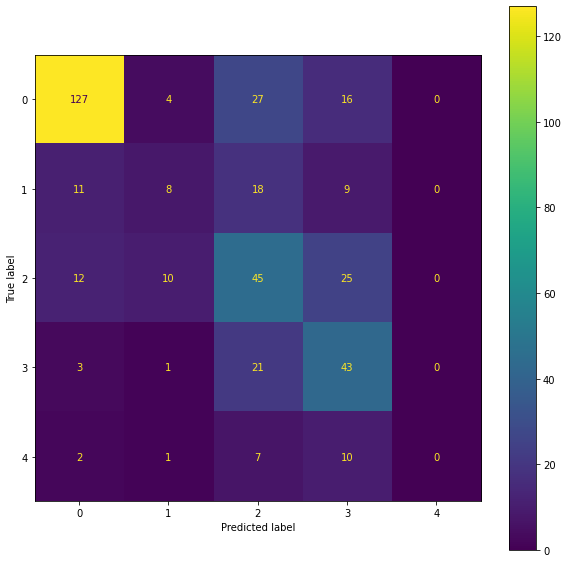

In [39]:
cm = confusion_matrix(target,classes_x_fun)
cm_display = ConfusionMatrixDisplay(cm,display_labels=['0','1','2','3','4'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)

In [40]:
print(classification_report(target, classes_x_fun))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       174
           1       0.33      0.17      0.23        46
           2       0.38      0.49      0.43        92
           3       0.42      0.63      0.50        68
           4       0.00      0.00      0.00        20

    accuracy                           0.56       400
   macro avg       0.39      0.41      0.39       400
weighted avg       0.55      0.56      0.55       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


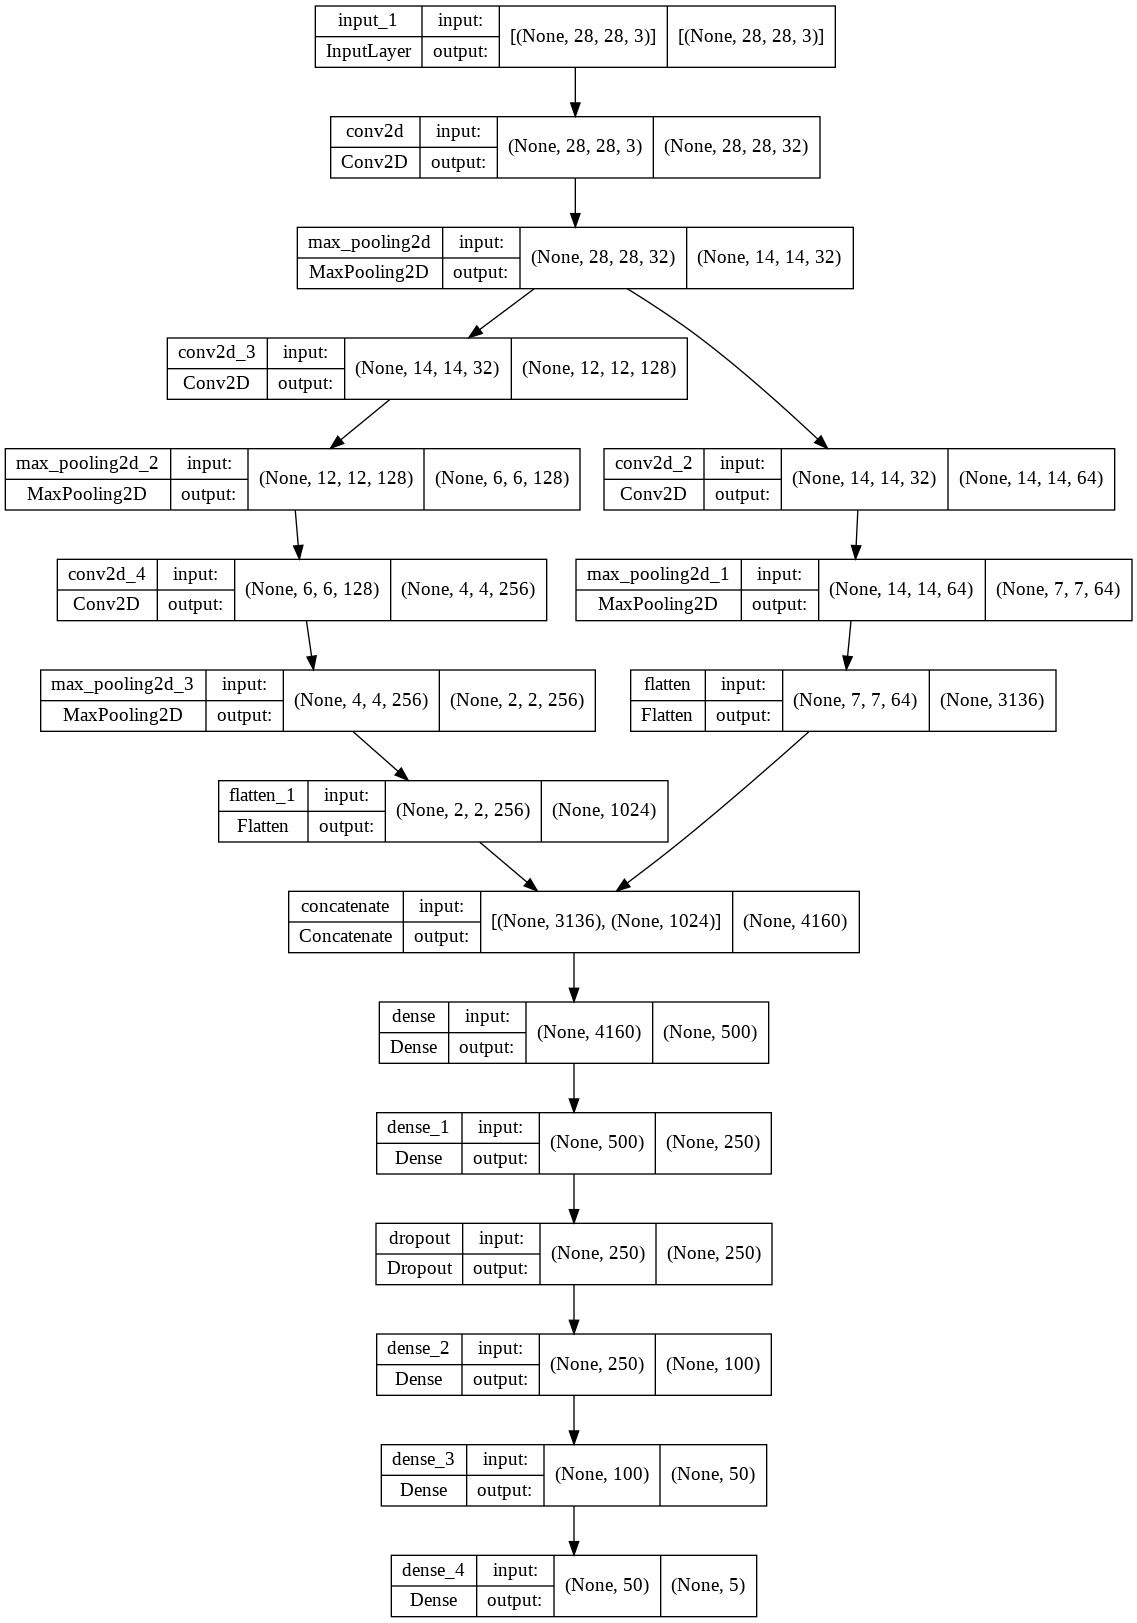

In [41]:
tf.keras.utils.plot_model(network_functional, show_shapes=True)

In [42]:
network_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 12, 12, 128)  36992       ['max_pooling2d[0][0]']          
                                                                                              

In [43]:
network_functional.save('best_functional_model_56_acc.h5')